In [2]:
import os
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.io import loadmat

In [3]:
df = loadmat('/voyager/datasets/UCI/uci_heart_processed.mat')
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'nthread': 4,
    'tree_method': 'gpu_hist'
}

bst = xgb.Booster(params)
bst.load_model('/voyager/datasets/UCI/xgb_seed=0.model')

data = {}
for key in ['train', 'iid_test', 'val', 'ood_test']:
    data[key] = xgb.DMatrix(df[f'{key}_data'], label=df[f'{key}_labels'])

In [21]:
iid_auc = []
ood_auc = []

for seed in range(10):
    if os.path.exists(f'/voyager/datasets/UCI/xgb_{seed=}.model'):
        bst = xgb.Booster(params)
        bst.load_model(f'/voyager/datasets/UCI/xgb_{seed=}.model')
        iid_auc.append(float(bst.eval(data['iid_test']).split(':')[1]))
        ood_auc.append(float(bst.eval(data['ood_test']).split(':')[1]))
    else:
        evallist = [(data['val'], 'eval'), (data['train'], 'train')]
        params['seed'] = seed
        num_round = 10
        bst = xgb.train(params, data['train'], num_round, evallist)

        iid_auc.append(float(bst.eval(data['iid_test']).split(':')[1]))
        ood_auc.append(float(bst.eval(data['ood_test']).split(':')[1]))

        bst.save_model(f'/voyager/datasets/UCI/xgb_{seed=}.model')

print(f'{np.mean(iid_auc):.3f} +- {np.std(iid_auc):.3f}')
print(f'{np.mean(ood_auc):.3f} +- {np.std(ood_auc):.3f}')

0.902 +- 0.008
0.707 +- 0.015


In [22]:
def to_max_prob(x):
    if x < 0.5:
        return 1 - x
    else:
        return x

In [3]:
def entropy(x):
    epsilon = 1e-8
    e = (1 - x) * np.log(1 - x + epsilon) + x * np.log(x + epsilon)
    return -e


def ensemble_entropy(x):
    return entropy(np.mean(x, axis=0))

<AxesSubplot:ylabel='Density'>

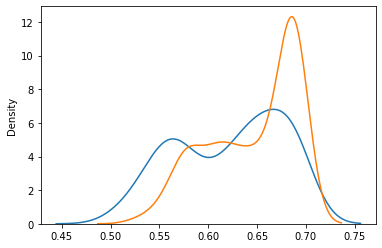

In [4]:
sns.kdeplot(entropy(bst.predict(data['iid_test'])))
sns.kdeplot(entropy(bst.predict(data['ood_test'])))

In [34]:
from tqdm.notebook import tqdm

record = {}
evallist = [(data['val'], 'eval')]
preds = {}

In [36]:
for seed in tqdm(range(10)):
    for shift in [True, False]:
        test = f'{"ood" if shift else "iid"}_test_data'
        for samples in [10, 20, 50]:
            # print(f'{samples} samples, {shift} shift')

            rnd = random.Random(seed)
            rng = rnd.sample(range(df[test].shape[0]), samples)
            test_set = df[test][rng]
            orig_test_set = xgb.DMatrix(df[test][rng])

            n_test = samples
            test_data = xgb.DMatrix(test_set)

            test_pred = bst.predict(test_data) > 0.5
            data_ = np.concatenate([df['train_data'], test_set])
            labels = np.concatenate([df['train_labels'][0], 1 - test_pred])
            weights = np.concatenate([np.ones_like(df['train_labels'][0]), 1 / (n_test + 1) * np.ones(n_test)])

            pq_data = xgb.DMatrix(data_, label=labels, weight=weights)

            num_round = 10
            data_test = data[test.replace('_data', '')]
            record[(seed, samples, shift)] = [
                {
                    'iteration': 0,
                    'val_auc': eval(bst.eval(data['val']).split(':')[1]),
                    'test_auc': eval(bst.eval(data_test).split(':')[1]),
                    'test_reject': 0,
                }
            ]
            preds[(seed, samples, shift)] = []
            for i in range(10):
                params['seed'] = i
                c = xgb.train(params, pq_data, num_round, evals=evallist, verbose_eval=False)
                mask = ((c.predict(test_data) > 0.5) == test_pred)
                test_set = test_set[mask]
                preds[(seed, samples, shift)].append(c.predict(orig_test_set))

                n_test = test_set.shape[0]
                record[(seed, samples, shift)].append({
                    'iteration': i + 1,
                    'val_auc': eval(c.eval(data['val']).split(':')[1]),
                    'test_auc': eval(c.eval(data_test).split(':')[1]),
                    'test_reject': 1 - n_test / samples,
                    'seed': seed,
                    'samples': samples,
                    'shift': shift
                })
                if n_test == 0:
                    break

                test_data = xgb.DMatrix(test_set)
                test_pred = bst.predict(test_data) > 0.5
                data_ = np.concatenate([df['train_data'], test_set])
                labels = np.concatenate([df['train_labels'][0], 1 - test_pred])
                weights = np.concatenate([np.ones_like(df['train_labels'][0]), 1 / (n_test + 1) * np.ones(n_test)])

                pq_data = xgb.DMatrix(data_, label=labels, weight=weights)

        x = record[(seed, samples, shift)]
        x = pd.DataFrame(x)
        x.to_csv(f'../checkpoints/uci/detectron/{seed=}_{samples=}_{shift=}.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
samples = 20
shift = True
seed = 0
test = f'{"ood" if shift else "iid"}_test_data'
rnd = random.Random(seed)
rng = rnd.sample(range(df[test].shape[0]), samples)
test_set = df[test][rng]
orig_test_set = xgb.DMatrix(df[test][rng])

n_test = samples
test_data = xgb.DMatrix(test_set)

tr_label = np.ones_like(df['train_labels'][0])
te_label = np.zeros(n_test)
data_ = np.concatenate([df['train_data'], test_set])
labels = np.concatenate([tr_label, te_label])
weights = np.concatenate([tr_label, 2 * np.ones(n_test)])
pq_data = xgb.DMatrix(data_, label=labels, weight=weights)
params['eval_metric'] = 'error'

c = xgb.train(params, pq_data, 10, evals=[(pq_data, 'pq')], verbose_eval=True)

[0]	pq-error:0.04020
[1]	pq-error:0.04271
[2]	pq-error:0.03769
[3]	pq-error:0.03015
[4]	pq-error:0.03518
[5]	pq-error:0.03518
[6]	pq-error:0.03518
[7]	pq-error:0.03015
[8]	pq-error:0.03518
[9]	pq-error:0.03015


In [30]:
(c.predict(orig_test_set) < 0.5).mean()

0.7

In [ ]:
for seed in tqdm(range(10)):
    for shift in [True, False]:
        test = f'{"ood" if shift else "iid"}_test_data'
        for samples in [10, 20, 50]:
            # print(f'{samples} samples, {shift} shift')

            rnd = random.Random(seed)
            rng = rnd.sample(range(df[test].shape[0]), samples)
            test_set = df[test][rng]
            orig_test_set = xgb.DMatrix(df[test][rng])

            n_test = samples
            test_data = xgb.DMatrix(test_set)

            tr_label = np.ones_like(df['train_labels'][0])
            te_label = np.zeros(n_test)
            data_ = np.concatenate([df['train_data'], test_set])
            labels = np.concatenate([tr_label, te_label])
            weights = np.concatenate([tr_label, 1 / (n_test + 1) * np.ones(n_test)])

            pq_data = xgb.DMatrix(data_, label=labels, weight=weights)

            num_round = 10
            data_test = data[test.replace('_data', '')]
            record[(seed, samples, shift)] = [
                {
                    'iteration': 0,
                    'test_reject': 0,
                }
            ]
            preds[(seed, samples, shift)] = []
            for i in range(10):
                params['seed'] = i
                c = xgb.train(params, pq_data, num_round, evals=evallist, verbose_eval=False)
                mask = ((c.predict(test_data) > 0.5) == te_label)
                test_set = test_set[mask]
                preds[(seed, samples, shift)].append(c.predict(orig_test_set))

                n_test = test_set.shape[0]
                record[(seed, samples, shift)].append({
                    'iteration': i + 1,
                    'test_reject': 1 - n_test / samples,
                    'seed': seed,
                    'samples': samples,
                    'shift': shift
                })
                if n_test == 0:
                    break

                tr_label = np.ones_like(df['train_labels'][0])
                te_label = np.zeros(n_test)
                data_ = np.concatenate([df['train_data'], test_set])
                labels = np.concatenate([tr_label, te_label])
                weights = np.concatenate([tr_label, 1 / (n_test + 1) * np.ones(n_test)])

                pq_data = xgb.DMatrix(data_, label=labels, weight=weights)

        x = record[(seed, samples, shift)]
        x = pd.DataFrame(x)
        x.to_csv(f'../checkpoints/uci/detectron/{seed=}_{samples=}_{shift=}.csv', index=False)

In [5]:
# with open('../checkpoints/uci/iid_ood_preds.pkl', 'wb') as f:
#     pickle.dump(preds, f)

# # start here to simply load the results
with open('../checkpoints/uci/iid_ood_record.pkl', 'rb') as f:
    record = pickle.load(f)

In [14]:
from glob import glob
def load(samples, shift):
    x = pd.concat([pd.read_csv(f) for f in glob(f'../checkpoints/uci/detectron/*{samples=}_{shift=}.csv')])
    return x.reset_index(drop=True)

In [13]:
load(10, True)

,iteration,val_auc,test_auc,test_reject,seed,samples,shift
0,0,0.876555,0.710645,0.0,NaN,NaN,NaN
1,1,0.873303,0.714497,0.2,92.0,10.0,True
2,2,0.864819,0.682974,0.4,92.0,10.0,True
3,3,0.854355,0.696135,0.4,92.0,10.0,True
4,4,0.845023,0.722329,0.5,92.0,10.0,True
...,...,...,...,...,...,...,...
6,6,0.855911,0.702234,0.2,33.0,10.0,True
7,7,0.861991,0.707595,0.2,33.0,10.0,True
8,8,0.872738,0.728846,0.3,33.0,10.0,True
9,9,0.837245,0.682910,0.3,33.0,10.0,True


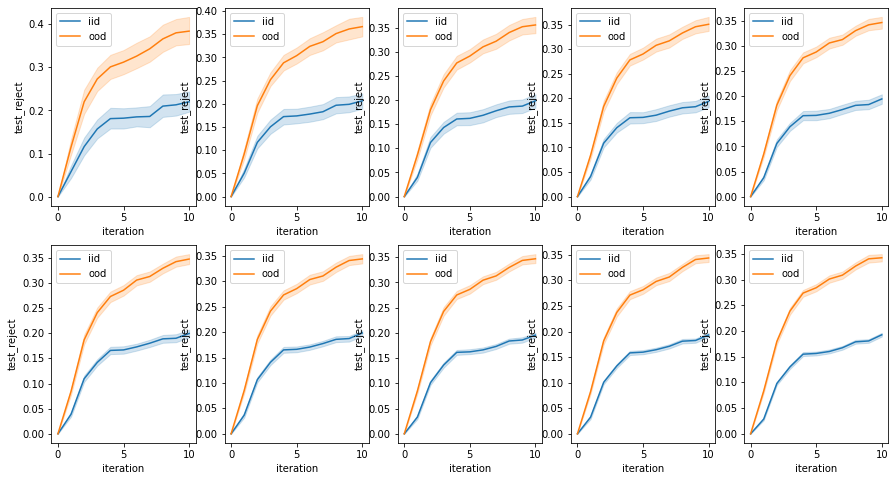

In [19]:
samples = 50
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
for ax, samples in zip(axs.ravel(), range(10, 101, 10)):
    x = load(samples, False)
    sns.lineplot(x='iteration', y='test_reject', data=x, ax=ax, label='iid')

    x = load(samples, True)
    sns.lineplot(x='iteration', y='test_reject', data=x, ax=ax, label='ood')
    #
    # ax.set_title(f'{samples} Samples')
    # ax.set_xlabel('Ensemble Size')
    # ax.set_ylabel('Rejection Rate')
    # if samples == 10:
    #     ax.legend(loc='lower right')

In [41]:
import os

os.makedirs('../checkpoints/uci/detectron', exist_ok=True)
for (seed, samples, shift), x in record.items():
    df = pd.DataFrame(x)
    df['test_reject'] = df.rejection_rate
    df.to_csv(f'../checkpoints/uci/detectron/{seed=}_{samples=}_{shift=}.csv', index=False)

In [37]:
from scipy.stats import ks_2samp, barnard_exact, fisher_exact
from functools import cache
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm

In [22]:
def load_preds(seed, samples, shift):
    f = f'../checkpoints/uci/detectron/preds_{seed=}_{samples=}_{shift=}.pkl'
    return pickle.load(open(f, 'rb'))


def load_results(seed, samples, shift):
    f = f'../checkpoints/uci/detectron/{seed=}_{samples=}_{shift=}.csv'
    return pd.read_csv(f)

In [41]:
def contingency_test(rp, rq, n, method='barnard'):
    rp = round(rp * n)
    rq = round(rq * n)
    table = [[rq, rp], [n - rq, n - rp]]
    if method == 'barnard':
        return barnard_exact(table, alternative='greater').pvalue
    elif method == 'fisher':
        return fisher_exact(table, alternative='greater')[0]
    else:
        raise ValueError(f'Unknown method: {method}')

In [42]:
@cache
def pvals(samples, hypothesis=True, method='entropy'):
    if method == 'entropy':
        pvals = []
        for i in range(100):
            for j in range(100):
                if hypothesis == False and i == j:
                    continue
                pval = ks_2samp(ensemble_entropy(np.stack(load_preds(i, samples, hypothesis))),
                                ensemble_entropy(np.stack(load_preds(j, samples, False)))).pvalue
                pvals.append(pval)
    elif method == 'dis':
        pvals = []
        for i in range(100):
            for j in range(100):
                if hypothesis == False and i == j:
                    continue
                q_rej = load_results(i, samples, hypothesis).test_reject.iloc[-1]
                p_rej = load_results(j, samples, False).test_reject.iloc[-1]
                pval = contingency_test(p_rej, q_rej, samples, method='fisher')
                pvals.append(pval)
    else:
        raise ValueError(f'Unknown method: {method}')
    return np.array(pvals)

In [44]:
aucs = []
avps = []

aucs_dis = []
avps_dis = []

for samples in tqdm(range(10, 101, 10)):
    s = pvals(samples, hypothesis=True)
    n = pvals(samples, hypothesis=False)
    fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
                              y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
    auc = np.trapz(tpr, fpr)
    roc_func = interp1d(fpr, tpr)
    aucs.append(auc)

    s = pvals(samples, hypothesis=True, method='dis')
    n = pvals(samples, hypothesis=False, method='dis')
    fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
                              y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
    auc = np.trapz(tpr, fpr)
    roc_func = interp1d(fpr, tpr)
    aucs_dis.append(auc)
    avps_dis.append(roc_func(0.05))

plt.plot(range(10, 101, 10), aucs, label='AUC')
plt.plot(range(10, 101, 10), avps, label='AP@5')

plt.plot(range(10, 101, 10), aucs_dis, label='AUC Dis')
plt.plot(range(10, 101, 10), avps_dis, label='AP@5 Dis')
plt.legend()
plt.xlabel('Number of Test Samples');

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

td@5%fd=17.09, auc=0.675
td@5%fd=36.27, auc=0.810
td@5%fd=56.85, auc=0.889
td@5%fd=77.51, auc=0.950
td@5%fd=92.83, auc=0.985
td@5%fd=96.79, auc=0.994
td@5%fd=99.85, auc=1.000
td@5%fd=100.00, auc=1.000
td@5%fd=100.00, auc=1.000
td@5%fd=100.00, auc=1.000


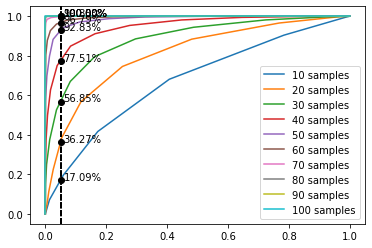

In [15]:
for samples in range(10, 101, 10):
    s = pvals(samples, hypothesis=True)
    n = pvals(samples, hypothesis=False)
    fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
                              y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
    roc_func = interp1d(fpr, tpr)
    auc = np.trapz(tpr, fpr)
    print(f'td@5%fd={100 * roc_func(0.05):.2f}, auc={auc:.3f}')
    plt.plot(fpr, tpr, label=f'{samples} samples')
    plt.axvline(x=0.05, linestyle='--', color='k')
    plt.plot(0.05, roc_func(0.05), 'o', color='k')
    plt.text(0.06, roc_func(0.05), f'{100 * roc_func(0.05):.2f}%')
plt.legend();

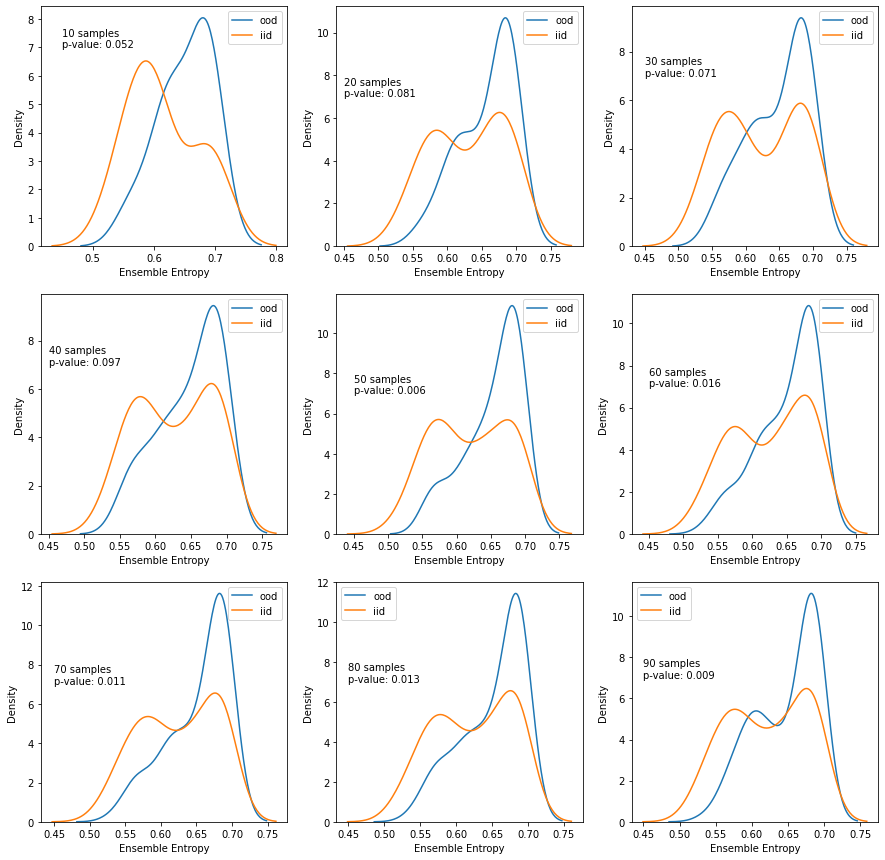

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for n, ax in zip(range(10, 101, 10), axs.ravel()):
    samples = []
    for s in [True, False]:
        smp = ensemble_entropy(np.stack(load_preds(0, n, s)))
        sns.kdeplot(smp, label='ood' if s else 'iid', ax=ax)
        samples.append(smp)
    stat = ks_2samp(samples[0], samples[1])
    ax.legend()
    ax.text(0.45, 7, f'{n} samples\np-value: {stat.pvalue:.3f}')
    ax.set_xlabel('Ensemble Entropy')
    ax.set_ylabel('Density')